Carpeta para guardar score maps: /home/imercatoma/FeatUp/graficas_evaluacion_wood/combined17/mahalanobis_score_maps
Cargando datos del coreset...
Coreset cargado. Dimensión: torch.Size([6323, 384])
NearestNeighbors finder inicializado.
Cargando modelo DINOv2...


Using cache found in /home/imercatoma/.cache/torch/hub/facebookresearch_dinov2_main


Modelo DINOv2 cargado.
Cargando modelo SAM2 desde /home/imercatoma/sam2_repo_independent/checkpoints/sam2.1_hiera_small.pt...
Modelo SAM2 cargado.

--- Procesando imagen: /home/imercatoma/FeatUp/datasets/mvtec_anomaly_detection/wood/test/combined/000.png ---
Ground Truth Mask Path para 000: /home/imercatoma/FeatUp/datasets/mvtec_anomaly_detection/wood/ground_truth/combined/000_mask.png

Buscando imágenes similares usando el banco pre-aplanado del Coreset...
dimension mapa query torch.Size([1, 384, 16, 16])
dimension query flatten (98304,)
dimension query flatten (247, 98304)
dimensiones desde BANCO STAGE 1 stage torch.Size([247, 98304])
Tiempo para calcular distancias KNN: 0.6962 segundos
Dimensiones imagen SAM: (1024, 1024, 3)
Generando máscaras para consulta con grid de 8x8 puntos...
Número de máscaras generadas (SIn de filtrar): 1
Máscara 1 guardada en: /home/imercatoma/FeatUp/graficas_evaluacion_wood/combined17/000/processed_masks/query_mask_1.png

Generando máscaras SAM para imáge

KeyboardInterrupt: 

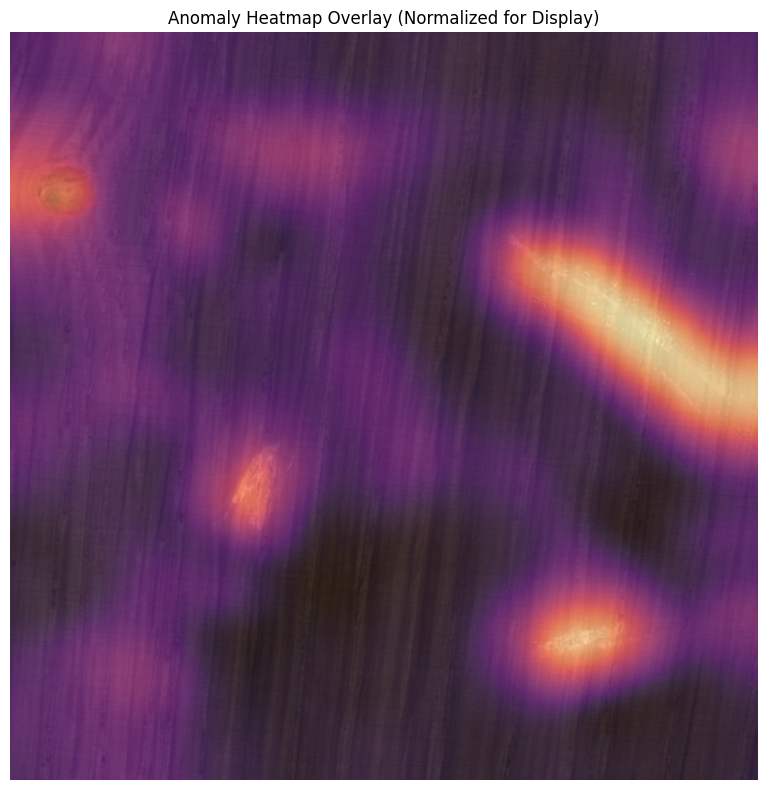

In [4]:
import torch
import torch.nn as nn
import numpy as np
import os
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import torchvision.transforms as T
import time
import glob
import pandas as pd
from sklearn.metrics import roc_auc_score
# FeatUp utilities
from featup.util import norm, unnorm
from featup.plotting import plot_feats

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter
from scipy.stats import median_abs_deviation

# Anomaly region detection and visualization
from skimage import measure
import matplotlib.patches as patches

# SAM2 imports
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2

# PCA for manual visualization
from sklearn.decomposition import PCA
# --- Enable loading of truncated images ---
ImageFile.LOAD_TRUNCATED_IMAGES = True # Add this at the very top for global effect

# --- Configuración ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 224  # DINOv2 input size
BACKBONE_PATCH_SIZE = 14  # DINOv2 ViT-S/14 patch size
use_norm = True

H_prime = input_size // BACKBONE_PATCH_SIZE
W_prime = input_size // BACKBONE_PATCH_SIZE

# Directorios
TRAIN_GOOD_DIR = '/home/imercatoma/FeatUp/datasets/mvtec_anomaly_detection/wood/train/good'
directorio_coreset = '/home/imercatoma/FeatUp/datasets/mvtec_anomaly_detection/wood/train/good/archivos_coreset'
#PLOT_SAVE_ROOT_DIR = '/home/imercatoma/FeatUp/plots_final_eval/cut'
# --- Imagen de Consulta ---
BASE_PLOT_SAVE_ROOT_DIR = '/home/imercatoma/FeatUp/graficas_evaluacion_wood/combined17'

# Directory containing the test images 
TEST_IMAGES_DIR = '/home/imercatoma/FeatUp/datasets/mvtec_anomaly_detection/wood/test/combined'

# Create parent plot directory if it doesn't exist
os.makedirs(BASE_PLOT_SAVE_ROOT_DIR, exist_ok=True)

# --- NUEVA CARPETA PARA LOS MAPAS DE ANOMALÍAS ---
MAHALANOBIS_SCORE_MAPS_DIR = os.path.join(BASE_PLOT_SAVE_ROOT_DIR, 'mahalanobis_score_maps')
os.makedirs(MAHALANOBIS_SCORE_MAPS_DIR, exist_ok=True)
print(f"Carpeta para guardar score maps: {MAHALANOBIS_SCORE_MAPS_DIR}")

# Coreset file paths
core_bank_filenames_file = os.path.join(directorio_coreset, 'core_bank_filenames.pt')
coreset_relevant_flat_features_bank_file = os.path.join(directorio_coreset, 'coreset_relevant_flat_features_bank.pt')
template_features_bank_coreset_file = os.path.join(directorio_coreset, 'template_features_bank_coreset.pt')

# --- Cargar Datos del Coreset ---
print("Cargando datos del coreset...")
try:
    coreset_relevant_filenames = torch.load(core_bank_filenames_file)
    coreset_relevant_flat_features_bank = torch.load(coreset_relevant_flat_features_bank_file).to(device)
    coreset_features = torch.load(template_features_bank_coreset_file).to(device)
    print(f"Coreset cargado. Dimensión: {coreset_features.shape}")
except Exception as e:
    print(f"ERROR al cargar archivos del coreset: {e}. Asegúrate de que la Etapa 1 se ejecutó.")
    exit()

# Mover coreset a CPU para sklearn's NearestNeighbors
coreset_features_cpu = coreset_features.cpu().numpy()
# se calcula la distancia coseno == 1 - similitud coseno [0,1] 0 identico, 1 completamente diferente
nn_finder = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(coreset_features_cpu)
print("NearestNeighbors finder inicializado.")

# --- Cargar Modelo DINOv2 ---
print("Cargando modelo DINOv2...")
featup_local_path = "/home/imercatoma/FeatUp"
upsampler = torch.hub.load(featup_local_path, 'dinov2', use_norm=use_norm, source='local').to(device)

dinov2_model = upsampler.model
dinov2_model.eval()
print("Modelo DINOv2 cargado.")

# --- Transformación de Imagen ---
transform = T.Compose([
    T.Resize(input_size),
    T.CenterCrop((input_size, input_size)),
    T.ToTensor(),
    norm
])

# --- Carga del Modelo SAM2 ---
print(f"Cargando modelo SAM2 desde /home/imercatoma/sam2_repo_independent/checkpoints/sam2.1_hiera_small.pt...")
checkpoint = "/home/imercatoma/sam2_repo_independent/checkpoints/sam2.1_hiera_small.pt"
model_cfg_name = "configs/sam2.1/sam2.1_hiera_s.yaml"
sam2_model = build_sam2(model_cfg_name, checkpoint, device=device, apply_postprocessing=True)
sam2_model.eval()
print("Modelo SAM2 cargado.")

#### fin de carga de modelos

# --- CONFIGURACIÓN PARA EL GUARDADO DE EXCEL ---
EXCEL_OUTPUT_PATH = 'resultados_evaluacion_anomalias.xlsx'
all_evaluation_results = [] # This list will accumulate results from all processed images

# Opción 2: Procesar solo las primeras 10 imágenes (descomentar si prefieres esta opción)
image_paths = glob.glob(os.path.join(TEST_IMAGES_DIR, '*.png'))
image_paths.sort()

######
start_time_global = time.time()
# --- Bucle para procesar cada imagen ---
for query_image_path in image_paths:
    start_time_total = time.time()
    print(f"\n--- Procesando imagen: {query_image_path} ---")

    # Extraer el nombre base de la imagen (ej: '006.png')
    base_image_name_with_ext = os.path.basename(query_image_path)
    base_image_name = os.path.splitext(base_image_name_with_ext)[0] # '006'

    # Construir la ruta de la máscara Ground Truth para la imagen actual
    gt_mask_path = query_image_path.replace('test', 'ground_truth').replace('.png', '_mask.png')
    print(f"Ground Truth Mask Path para {base_image_name}: {gt_mask_path}")

    # --- Directorios de guardado específicos para esta imagen ---
    PLOT_SAVE_ROOT_DIR = os.path.join(BASE_PLOT_SAVE_ROOT_DIR, base_image_name)
    os.makedirs(PLOT_SAVE_ROOT_DIR, exist_ok=True)

    HEATMAPS_SAVE_DIR = os.path.join(PLOT_SAVE_ROOT_DIR, 'individual_heatmaps')
    os.makedirs(HEATMAPS_SAVE_DIR, exist_ok=True)

    ANOMALY_REGIONS_SAVE_DIR = os.path.join(PLOT_SAVE_ROOT_DIR, 'detected_anomaly_regions')
    os.makedirs(ANOMALY_REGIONS_SAVE_DIR, exist_ok=True)

    FEATUP_PLOTS_DIR = os.path.join(PLOT_SAVE_ROOT_DIR, 'featup_feature_plots')
    os.makedirs(FEATUP_PLOTS_DIR, exist_ok=True)

    # --- Cargar la imagen de consulta CON ERROR HANDLING ---
    query_img_pil = None # Initialize to None
    try:
        query_img_pil = Image.open(query_image_path).convert("RGB")
        W, H = query_img_pil.size # Get dimensions for consistent resizing
    except OSError as e:
        print(f"ERROR: No se pudo cargar o procesar la imagen de consulta '{query_image_path}'. Error: {e}")
        print("Saltando a la siguiente imagen...")
        continue # Skip to the next image in the loop

    # If query_img_pil is still None, it means an error occurred, so skip
    if query_img_pil is None:
        continue

    # Definir el tamaño objetivo para las máscaras de evaluación (el mismo que el mapa de anomalías)
    TARGET_EVAL_SIZE = (W, H)

    #############----------- PROCESO   -----###############
    
    input_tensor = transform(query_img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        features_lr = dinov2_model(input_tensor)

    query_lr_features = features_lr

    # --- Función para buscar imágenes similares usando KNN ---
    def buscar_imagenes_similares_knn(query_feature_map, pre_flattened_features_bank, k=3, nombres_archivos=None):
        query_feat_flatten = query_feature_map.flatten().cpu().numpy()#dimension mapa desde banco torch.Size([1, 384, 16, 16])
        print(f"dimension mapa query", query_feature_map.shape)
        print(f"dimension query flatten", query_feat_flatten.shape)#dimension query flatten (98304,)
        features_bank_for_knn = pre_flattened_features_bank.cpu().numpy() if isinstance(pre_flattened_features_bank, torch.Tensor) else pre_flattened_features_bank
        print(f"dimension query flatten", features_bank_for_knn.shape)#dimension query flatten (213, 98304)
        print(f"dimensiones desde BANCO STAGE 1 stage", pre_flattened_features_bank.shape)#dimensiones desde BANCO STAGE 1 stage torch.Size([213, 98304])
        
        
        start_time_knn_dist = time.time()
        distances = euclidean_distances([query_feat_flatten], features_bank_for_knn)
        nearest_indices = np.argsort(distances[0])[:k]
        end_time_knn_dist = time.time()
        print(f"Tiempo para calcular distancias KNN: {end_time_knn_dist - start_time_knn_dist:.4f} segundos")

        imagenes_similares = []
        rutas_imagenes_similares = []
        if nombres_archivos:
            for idx in nearest_indices:
                imagenes_similares.append(nombres_archivos[idx])
                rutas_imagenes_similares.append(os.path.join(TRAIN_GOOD_DIR, nombres_archivos[idx]))
        else: # Fallback if no filenames provided (less common for this use case)
            for idx in nearest_indices:
                imagenes_similares.append(f"Imagen_Banco_{idx:03d}.png")
                rutas_imagenes_similares.append(os.path.join(TRAIN_GOOD_DIR, f"Imagen_Banco_{idx:03d}.png"))
        return imagenes_similares, rutas_imagenes_similares, end_time_knn_dist

    # --- Búsqueda KNN ---
    print("\nBuscando imágenes similares usando el banco pre-aplanado del Coreset...")
    imagenes_similares, rutas_imagenes_similares, time_knn_dist = buscar_imagenes_similares_knn(
        query_lr_features, coreset_relevant_flat_features_bank, nombres_archivos=coreset_relevant_filenames
    )

    # --- Aplicar FeatUp para obtener características de alta resolución ---
    def apply_featup_hr(image_path, featup_upsampler, image_transform, device):
        image_pil = Image.open(image_path).convert("RGB")
        image_tensor = image_transform(image_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            lr_feats = featup_upsampler.model(image_tensor)
            hr_feats = featup_upsampler(image_tensor)
        return lr_feats.cpu(), hr_feats.cpu()

    # Características de la imagen de consulta
    input_query_tensor_original = transform(Image.open(query_image_path).convert("RGB")).unsqueeze(0).to(device)
    query_lr_feats_featup, query_hr_feats = apply_featup_hr(query_image_path, upsampler, transform, device)

    # Características de las imágenes similares
    similar_hr_feats_list = []
    for j, similar_image_path in enumerate(rutas_imagenes_similares):
        input_similar_tensor_original = transform(Image.open(similar_image_path).convert("RGB")).unsqueeze(0).to(device)
        similar_lr_feats, similar_hr_feats = apply_featup_hr(similar_image_path, upsampler, transform, device)
        similar_hr_feats_list.append(similar_hr_feats)

    ################################
    ### Aplicando Máscaras SAM query y similares

    def show_mask(mask, ax, random_color=False, borders=True):
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0) if random_color else np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image_alpha = np.zeros((h, w, 4), dtype=np.float32)
        mask_image_alpha[mask > 0] = color
        if borders:
            mask_uint8 = mask.astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contour_image = np.zeros((h, w, 3), dtype=np.uint8)
            cv2.drawContours(contour_image, contours, -1, (255, 255, 255), thickness=2)
            contour_mask = (contour_image.astype(np.float32) / 255.0).sum(axis=-1) > 0
            mask_image_alpha[contour_mask > 0, :3] = 1.0
            mask_image_alpha[contour_mask > 0, 3] = 0.5
        ax.imshow(mask_image_alpha)

    def process_masks_with_hierarchy(image, masks, output_dir, filename_prefix, overlap_threshold=0.8):
        os.makedirs(output_dir, exist_ok=True)
        
        final_processed_masks_data = [] 
        original_mask_segments_for_comparison = [mask_data["segmentation"] for mask_data in masks]

        print(f"Procesando jerárquicamente {len(masks)} máscaras...")

        for i, mask_data_a_original in enumerate(masks): 
            mask_data_a_processed = mask_data_a_original.copy() 
            mask_a_current_processing = np.copy(mask_data_a_original["segmentation"]) 

            is_completely_internal_to_another = False 
            potential_holes_for_mask_a = [] 

            for j, mask_data_b_comparison in enumerate(masks): 
                if i == j:
                    continue

                mask_b = original_mask_segments_for_comparison[j] 

                if np.sum(mask_a_current_processing) > 0 and np.all(np.logical_and(mask_a_current_processing, mask_b) == mask_a_current_processing):
                    is_completely_internal_to_another = True
                    break 

                intersection_ab = np.logical_and(mask_b, mask_a_current_processing)
                area_b = np.sum(mask_b)
                area_intersection_ab = np.sum(intersection_ab)

                if area_b > 0 and (np.all(intersection_ab == mask_b) or \
                                (area_intersection_ab / area_b > overlap_threshold and area_intersection_ab > 0)):
                    if np.sum(mask_b) < np.sum(mask_a_current_processing) * 0.9: 
                        potential_holes_for_mask_a.append(mask_b)

            if is_completely_internal_to_another:
                display_title = f'Máscara {i + 1} (Interna - Sin cambios significativos)'
            else:
                hollowed = False
                for hole_mask in potential_holes_for_mask_a:
                    mask_a_current_processing = np.logical_and(mask_a_current_processing, np.logical_not(hole_mask))
                    hollowed = True
                
                mask_data_a_processed["segmentation"] = mask_a_current_processing 
                if hollowed:
                    display_title = f'Máscara {i + 1} (Externa - Hueca)'
                else:
                    display_title = f'Máscara {i + 1} (Externa - Sin huecos significativos)'

            final_processed_masks_data.append(mask_data_a_processed) 

            plt.figure(figsize=(8, 8))
            plt.imshow(image) 
            show_mask(mask_data_a_processed["segmentation"], plt.gca(), random_color=True) 
            plt.axis('off')
            plt.title(display_title)
            
            output_path = os.path.join(output_dir, f"{filename_prefix}_processed_mask_{i + 1}.png")
            plt.savefig(output_path, bbox_inches='tight')
            plt.close()
            print(f"Máscara procesada {i + 1} guardada en: {output_path}")

        print("Procesamiento jerárquico de máscaras completado.")
        return final_processed_masks_data 

    def apply_morphological_closing(masks_list, kernel_size=5):
        if not masks_list:
            return masks_list
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        print(f"Aplicando cierre morfológico con kernel {kernel_size}x{kernel_size}...")
        for mask_data in masks_list:
            mask_boolean = mask_data['segmentation']
            mask_np_255 = (mask_boolean * 255).astype(np.uint8)
            mask_smoothed_np = cv2.morphologyEx(mask_np_255, cv2.MORPH_CLOSE, kernel)
            mask_data['segmentation'] = (mask_smoothed_np > 0).astype(bool)
        print("Suavizado de máscaras completado.")
        return masks_list

    def apply_morphological_opening(masks_list, kernel_size=5):
        if not masks_list:
            print("La lista de máscaras está vacía, no se aplica la apertura morfológica.")
            return masks_list
        
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        print(f"Aplicando apertura morfológica con kernel {kernel_size}x{kernel_size}...")
        
        for mask_data in masks_list:
            mask_boolean = mask_data['segmentation']
            if mask_boolean.dtype != bool:
                mask_boolean = mask_boolean.astype(bool)

            mask_np_255 = (mask_boolean * 255).astype(np.uint8)
            mask_processed_np = cv2.morphologyEx(mask_np_255, cv2.MORPH_OPEN, kernel)
            mask_data['segmentation'] = (mask_processed_np > 0).astype(bool)
            
        print("Suavizado (apertura) de máscaras completado.")
        return masks_list

    try:
        image_for_sam_np = np.array(Image.open(query_image_path).convert("RGB"))
        print(f"Dimensiones imagen SAM: {image_for_sam_np.shape}")
    except Exception as e:
        print(f"Error procesando imagen para SAM: {e}. Saltando SAM.")
        sam2_model = None
        
    PROCESSED_MASKS_DIR = os.path.join(PLOT_SAVE_ROOT_DIR, "processed_masks")

    if sam2_model is not None:
        points_grid_density = 8
        min_mask_area_pixels = 3000

        mask_generator_query = SAM2AutomaticMaskGenerator(
            model=sam2_model,
            points_per_side=points_grid_density,
            points_per_batch=128,
            pred_iou_thresh=0.7,
            stability_score_thresh=0.6,
            crop_n_layers=0,
            min_mask_region_area=min_mask_area_pixels,
        )
        max_mask_area_pixels = 1024*1024
        print(f"Generando máscaras para consulta con grid de {points_grid_density}x{points_grid_density} puntos...")
        
        
        masks_data_query_image = mask_generator_query.generate(image_for_sam_np)
        
        # Reemplazar masks_data_query_image con toda la imagen sin excepción
        # Crear una máscara que cubra toda la imagen
        full_image_mask = np.ones(image_for_sam_np.shape[:2], dtype=bool)  # Máscara binaria que cubre toda la imagen

        # Crear un diccionario con la estructura esperada por el mask generator
        masks_data_query_image = [{
            'segmentation': full_image_mask,
            'area': full_image_mask.sum(),
            'bbox': [0, 0, image_for_sam_np.shape[1], image_for_sam_np.shape[0]],  # Bounding box que cubre toda la imagen
            'predicted_iou': 1.0,  # IoU máximo ya que cubre toda la imagen
            'point_coords': None,  # Sin puntos específicos
            'stability_score': 1.0,  # Máxima estabilidad
            'crop_box': [0, 0, image_for_sam_np.shape[1], image_for_sam_np.shape[0]]  # Caja de recorte que cubre toda la imagen
        }]
        print(f"Número de máscaras generadas (SIn de filtrar): {len(masks_data_query_image)}")
        # # Quedarse solo con el área más grande
        # if filtered_masks_data:
        #     masks_data_query_image = [max(filtered_masks_data, key=lambda mask: mask['area'])]
        # else:
        #     masks_data_query_image = []
        
         #processed_masks_query = process_masks_with_hierarchy(image_for_sam_np, masks_data_query_image, PROCESSED_MASKS_DIR, "query")
        for i, mask_data in enumerate(masks_data_query_image):
            plt.figure(figsize=(8, 8))
            mask_np = mask_data["segmentation"]
            plt.imshow(mask_np, cmap='gray')
            plt.axis('off')
            plt.title(f"Máscara {i + 1} - Área: {mask_data['area']}, IoU: {mask_data['predicted_iou']:.4f}")
            
            if not os.path.exists(PROCESSED_MASKS_DIR):
                os.makedirs(PROCESSED_MASKS_DIR)
            output_path = os.path.join(PROCESSED_MASKS_DIR, f"query_mask_{i + 1}.png")
            plt.savefig(output_path, bbox_inches='tight')
            plt.close()
            print(f"Máscara {i + 1} guardada en: {output_path}")

        
        #print(f"Número de máscaras generadas DESPUÉS de filtrar (área >= {min_area_threshold}): {len(masks_data_query_image)}")   
        
        mask_generator_similar = SAM2AutomaticMaskGenerator( 
            model=sam2_model,
            points_per_side=8,#25
            points_per_batch=128,
            pred_iou_thresh=0.7,
            stability_score_thresh=0.6,
            crop_n_layers=0,
            min_mask_region_area=3000,
        )

        print("\nGenerando máscaras SAM para imágenes similares...")
        similar_masks_raw_list = []
        mask_big = []
       
        # Initialize start_time_sam here, outside the loop
        start_time_sam = time.time()
        for j, similar_image_path in enumerate(rutas_imagenes_similares):
            
            try:
                image_np_similar_for_sam = np.array(Image.open(similar_image_path).convert('RGB'))
                print(f"--- Procesando vecino {j+1}: {os.path.basename(similar_image_path)} ---")
                filtered_masks_data =[]
                current_similar_masks_data = []
                mask_big = []
                current_similar_masks_data = mask_generator_similar.generate(image_np_similar_for_sam)
                # Filtrar por área mínima
                current_similar_masks_data = [
                    m for m in current_similar_masks_data 
                    if m['area'] >= 900*900 and m['area'] <= max_mask_area_pixels
                ]

                # # Filtrar máscaras que toquen algún borde de la imagen
                # filtered_masks_data = []
                # image_width, image_height = image_np_similar_for_sam.shape[1], image_np_similar_for_sam.shape[0]

                # for mask_data in current_similar_masks_data:
                #     bbox = mask_data['bbox']
                #     x_min, y_min, x_max, y_max = bbox[0], bbox[1], bbox[2], bbox[3]

                #     # Verificar si la máscara toca algún borde de la imagen
                #     touches_left = x_min <= 0
                #     touches_top = y_min <= 0
                #     touches_right = x_max >= image_width
                #     touches_bottom = y_max >= image_height

                #     # Calcular porcentaje de contacto con los bordes
                #     contact_percentage = 0
                #     if touches_left:
                #         contact_percentage += (y_max - y_min) / image_height
                #     if touches_top:
                #         contact_percentage += (x_max - x_min) / image_width
                #     if touches_right:
                #         contact_percentage += (y_max - y_min) / image_height
                #     if touches_bottom:
                #         contact_percentage += (x_max - x_min) / image_width

                #     # Filtrar máscaras que tengan al menos 1% de contacto con algún borde
                #     if contact_percentage < 0.01:
                #         filtered_masks_data.append(mask_data)
                #     else:
                #         print(f"Máscara descartada por tocar borde: Área={mask_data['area']}, IoU={mask_data['predicted_iou']:.4f}, Estabilidad={mask_data['stability_score']:.4f}")
                # print(f"Cantidad de máscaras filtradas por área mínima y contacto con bordes: {len(filtered_masks_data)}")
                
                # current_similar_masks_data = filtered_masks_data
                
                # # Filtrar por la máscara binaria que tiende más al centro
                # center_x, center_y = image_np_similar_for_sam.shape[1] // 2, image_np_similar_for_sam.shape[0] // 2

                # def binary_mask_distance_to_center(mask):
                #     mask_indices = np.argwhere(mask['segmentation'])
                #     if mask_indices.size == 0:
                #         return float('inf')  # Si la máscara está vacía, asignar una distancia infinita
                #     mask_center_x = mask_indices[:, 1].mean()
                #     mask_center_y = mask_indices[:, 0].mean()
                #     return np.sqrt((mask_center_x - center_x)**2 + (mask_center_y - center_y)**2)

                # if current_similar_masks_data:
                #     closest_to_center_mask = min(current_similar_masks_data, key=binary_mask_distance_to_center)
                #     # Asegurarse de que la máscara esté suficientemente centrada verificando su distancia al centro de la imagen
                #     max_distance_threshold = min(image_np_similar_for_sam.shape[1], image_np_similar_for_sam.shape[0]) * 0.25
                #     if binary_mask_distance_to_center(closest_to_center_mask) <= max_distance_threshold:
                #         current_similar_masks_data = [closest_to_center_mask]

                # Filtrar por el de mayor área
                if current_similar_masks_data:
                    max_area_mask = max(current_similar_masks_data, key=lambda m: m['area'])
                    mask_big = [max_area_mask]
                    print(f"Mayor área de máscara actualizada: {max_area_mask['area']}")
                    bbox = max_area_mask['bbox']
                    print(f"Bounding box de la máscara: {bbox}")
                    print(f"Predicted IoU de la máscara: {max_area_mask['predicted_iou']}")
                    print(f"Stability Score de la máscara: {max_area_mask['stability_score']}")
                    
                    # # Dibujar el bounding box en la imagen
                    # plt.figure(figsize=(8, 8))
                    # plt.imshow(image_np_similar_for_sam)
                    # rect = patches.Rectangle(
                    #     (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                    #     linewidth=2, edgecolor='red', facecolor='none'
                    # )
                    # plt.gca().add_patch(rect)
                    # plt.title(f"Bounding Box de la Máscara Mayor Área - Vecino {j+1}")
                    # plt.axis('off')
                    
                    # # Guardar la imagen con el bounding box
                    # bbox_save_path = os.path.join(PROCESSED_MASKS_DIR, f"bbox_similar_{j+1}.png")
                    # plt.savefig(bbox_save_path, bbox_inches='tight')
                    # plt.close()
                    # print(f"Bounding box dibujado y guardado en: {bbox_save_path}")
                        
                processed_masks_similar = process_masks_with_hierarchy(image_np_similar_for_sam, current_similar_masks_data, PROCESSED_MASKS_DIR, f"similar_{j+1}")
                for mask in processed_masks_similar:
                    print(f"Área de la máscara: {mask['area']}")
                similar_masks_raw_list.append(processed_masks_similar)
                
                print(f"Máscaras generadas para vecino {j+1}: {len(processed_masks_similar)}.")
                
            except Exception as e:
                print(f"Error procesando imagen similar {os.path.basename(similar_image_path)} para SAM: {e}")

        end_time_sam = time.time()
        print(f"Tiempo total de ejecución de SAM: {end_time_sam - start_time_sam:.4f} segundos.")

    print("\nAnálisis de detección de anomalías para una sola imagen completado.")
    
    # Llamar a la función para procesar las máscaras de la query
    # processed_masks_query = process_masks_with_hierarchy(image_for_sam_np, masks_data_query_image, PROCESSED_MASKS_DIR, "query")
    # masks_data_query_image = processed_masks_query
    # print("Shape de masks_data_query_image:", len(masks_data_query_image))

    #####################

    # --- Implementación del punto 3.4.3. Object Feature Map ---
    def process_masks_to_object_feature_maps(raw_masks, hr_feature_map, target_h, target_w, sam_processed_image_shape):
        if not raw_masks:
            print("Advertencia: No se encontraron máscaras para procesar. Devolviendo tensores vacíos.")
            C_dim = hr_feature_map.shape[0] if hr_feature_map.ndim >= 3 else 0
            return torch.empty(0, C_dim, target_h, target_w, device=hr_feature_map.device), \
                torch.empty(0, 1, target_h, target_w, device=hr_feature_map.device)

        object_feature_maps_list = []
        scaled_mask_append = []
        C_dim = hr_feature_map.shape[0] 

        for mask_info in raw_masks:
            mask_np = mask_info['segmentation'].astype(np.float32)
            mask_tensor_original_res = torch.from_numpy(mask_np).unsqueeze(0).unsqueeze(0) #(1,1,H,W)
            mask_tensor_original_res = mask_tensor_original_res.to(hr_feature_map.device)

            scaled_mask = F.interpolate(mask_tensor_original_res,
                                        size=(target_h, target_w),
                                        mode='bilinear',
                                        align_corners=False)
            scaled_mask = (scaled_mask > 0.5).float()
            scaled_mask_append.append(scaled_mask)
            
            if hr_feature_map.ndim == 3:
                hr_feature_map_with_batch = hr_feature_map.unsqueeze(0) #(1,C,W,H)
            else: 
                hr_feature_map_with_batch = hr_feature_map

            object_feature_map_i = scaled_mask * hr_feature_map_with_batch
            object_feature_maps_list.append(object_feature_map_i)

        final_object_feature_maps = torch.cat(object_feature_maps_list, dim=0) 
        final_scaled_masks = torch.cat(scaled_mask_append, dim=0)
        
        return final_object_feature_maps, final_scaled_masks

    # --- Visualización de Mapas de Características de Objeto ---
    def visualize_object_feature_map(original_image_path, sam_mask_info, hr_feature_map_tensor,
                                    object_feature_map_tensor, target_h, target_w,
                                    plot_save_dir, plot_filename_prefix, mask_idx,
                                    sam_processed_image_shape):
        try:
            original_img = Image.open(original_image_path).convert("RGB")
            sam_mask_np = sam_mask_info['segmentation']

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            axes[0].imshow(original_img)
            axes[0].set_title(f'Imagen Original\n{os.path.basename(original_image_path)}')
            axes[0].axis('off')

            mask_display = sam_mask_np 
            axes[1].imshow(original_img) 
            show_mask(mask_display, axes[1], random_color=False, borders=True) 
            axes[1].set_title(f'Máscara SAM {mask_idx}')
            axes[1].axis('off')

            if object_feature_map_tensor.numel() == 0:
                axes[2].text(0.5, 0.5, "No hay características de objeto", ha='center', va='center', transform=axes[2].transAxes)
                axes[2].set_title('Mapa de Características de Objeto (Vacío)')
                axes[2].axis('off')
            else:
                ofm_cpu = object_feature_map_tensor.squeeze().cpu().numpy() 
                if ofm_cpu.ndim == 3: 
                    C, H, W = ofm_cpu.shape
                    ofm_reshaped = ofm_cpu.transpose(1, 2, 0).reshape(-1, C) 

                    if C > 3: 
                        pca = PCA(n_components=3)
                        ofm_pca = pca.fit_transform(ofm_reshaped)
                        ofm_pca_normalized = (ofm_pca - ofm_pca.min()) / (ofm_pca.max() - ofm_pca.min() + 1e-8)
                        ofm_display = ofm_pca_normalized.reshape(H, W, 3)
                        axes[2].imshow(ofm_display)
                        axes[2].set_title(f'Mapa de Características de Objeto (PCA)\nMáscara {mask_idx}')
                    else: 
                        if C == 1:
                            ofm_display = ofm_cpu.squeeze()
                            axes[2].imshow(ofm_display, cmap='viridis')
                        elif C == 3:
                            ofm_display = ofm_cpu.transpose(1, 2, 0) 
                            ofm_display_norm = (ofm_display - ofm_display.min()) / (ofm_display.max() - ofm_display.min() + 1e-8)
                            axes[2].imshow(ofm_display_norm)
                        else: 
                            ofm_display = ofm_cpu[0]
                            axes[2].imshow(ofm_display, cmap='viridis')
                        axes[2].set_title(f'Mapa de Características de Objeto\nMáscara {mask_idx}')
                else: 
                    axes[2].text(0.5, 0.5, "Formato de características de objeto inesperado", ha='center', va='center', transform=axes[2].transAxes)
                    axes[2].set_title('Mapa de Características de Objeto (Error)')

                axes[2].axis('off')

            plt.tight_layout()
            save_path = os.path.join(plot_save_dir, f"{plot_filename_prefix}_mask_{mask_idx}.png")
            plt.savefig(save_path)
            plt.close(fig)

        except Exception as e:
            print(f"Error al visualizar el mapa de características de objeto para máscara {mask_idx} de {os.path.basename(original_image_path)}: {e}")

    # --- Aplicar el proceso a la imagen de consulta y a las imágenes de referencia ---

    print("\n--- Generando Mapas de Características de Objeto ---")

    TARGET_MASK_H = 8 * H_prime 
    TARGET_MASK_W = 8 * W_prime 
    print(f"TARGET_MASK_H: {TARGET_MASK_H}")
    print(f"TARGET_MASK_W: {TARGET_MASK_W}")

    fobj_q, scaled_masks_query = process_masks_to_object_feature_maps(
        masks_data_query_image,
        query_hr_feats.squeeze(0), 
        TARGET_MASK_H,
        TARGET_MASK_W,
        image_for_sam_np.shape 
    )

    fobj_q = fobj_q.to(device)

    print(f"Dimensiones de fobj_q (Mapas de Características de Objeto de Iq): {fobj_q.shape}") 

    all_fobj_r_list = [] 
    for i, similar_hr_feats in enumerate(similar_hr_feats_list):
        current_similar_masks_raw = similar_masks_raw_list[i]
        img_similar_pil = Image.open(rutas_imagenes_similares[i]).convert('RGB') 
        image_np_similar_for_sam_shape = np.array(img_similar_pil).shape

        fobj_r_current, scaled_masks_similar = process_masks_to_object_feature_maps(
            current_similar_masks_raw,
            similar_hr_feats.squeeze(0), 
            TARGET_MASK_H,
            TARGET_MASK_W,
            image_np_similar_for_sam_shape 
        )
        fobj_r_current = fobj_r_current.to(device)
        
        all_fobj_r_list.append(fobj_r_current)
        print(f"Dimensiones de fobj_r para vecino {i+1}: {fobj_r_current.shape}") 
        print("\nTipos de los elementos en all_fobj_r_list:")
        for idx, fobj_r in enumerate(all_fobj_r_list):
            print(f"Vecino {idx + 1}: Tipo de fobj_r:", type(fobj_r))
    print("\nProceso de 'Object Feature Map' completado. ¡Ahora tienes los fobj_q y fobj_r listos!")


    # -----------3.5.2 Object matching module-----------------
    ## Matching
    # --- Definición de la función show_anomalies_on_image ---
    def show_anomalies_on_image(image_np, masks, anomalous_info, alpha=0.5, save_path=None):

        plt.figure(figsize=(8, 8))
        plt.imshow(image_np)

        for obj_id, similarity in anomalous_info: # Iterate through (id, similarity) tuples
            # Extraer la máscara binaria real
            mask = masks[obj_id]['segmentation']
            if isinstance(mask, torch.Tensor):
                mask = mask.cpu().numpy()

            # Crear máscara en rojo
            colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
            colored_mask[mask > 0] = [255, 0, 0]
            plt.imshow(colored_mask, alpha=alpha)

            # Calcular centroide para colocar el texto
            ys, xs = np.where(mask > 0)
            if len(xs) > 0 and len(ys) > 0:
                cx = int(xs.mean())
                cy = int(ys.mean())
                
                # Create text with index and percentage
                text_label = f"{obj_id} ({similarity*100:.2f}%)"
                plt.text(cx, cy, text_label, color='white', fontsize=10, fontweight='bold', ha='center', va='center',
                        bbox=dict(facecolor='red', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

        plt.title("Objetos Anómalos en Rojo con Índice y Similitud") # Updated title for clarity
        plt.axis("off")

        if save_path:
            plt.tight_layout()
            plt.savefig(save_path)
            print(f"✅ Plot de anomalías guardado en: {save_path}")

        plt.show()
        plt.close()
    # --- Fin de la definición de la función show_anomalies_on_image ---
    # --- Nuevas funciones de ploteo para la matriz P y P_augmented_full ---
    def plot_assignment_matrix(P_matrix, query_labels, reference_labels, save_path=None, title="Matriz de Asignación P"):

        if isinstance(P_matrix, torch.Tensor):
            #P_matrix = P_matrix.cpu().numpy()
            P_matrix = P_matrix.detach().cpu().numpy()

        plt.figure(figsize=(P_matrix.shape[1] * 0.8 + 2, P_matrix.shape[0] * 0.8 + 2))
        plt.imshow(P_matrix, cmap='viridis', origin='upper', aspect='auto')
        plt.colorbar(label='Probabilidad de Asignación')
        plt.xticks(np.arange(len(reference_labels)), reference_labels, rotation=45, ha="right")
        plt.yticks(np.arange(len(query_labels)), query_labels)
        plt.xlabel('Objetos de Referencia')
        plt.ylabel('Objetos de Consulta')
        plt.title(title)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
            print(f"✅ Plot de la matriz de asignación guardado en: {save_path}")
        plt.show()
        plt.close()

    def plot_augmented_assignment_matrix(P_augmented_full, query_labels, reference_labels, save_path=None, title="Matriz de Asignación Aumentada (con Trash Bin)"):

        if isinstance(P_augmented_full, torch.Tensor):
            #P_augmented_full = P_augmented_full.cpu().numpy()
            P_augmented_full = P_augmented_full.detach().cpu().numpy()

        # Añadir etiquetas para los trash bins
        full_query_labels = [f"Q_{i}" for i in query_labels] + ["Trash Bin (Q)"]
        full_reference_labels = [f"R_{i}" for i in reference_labels] + ["Trash Bin (R)"]

        plt.figure(figsize=(P_augmented_full.shape[1] * 0.8 + 2, P_augmented_full.shape[0] * 0.8 + 2))
        plt.imshow(P_augmented_full, cmap='viridis', origin='upper', aspect='auto')
        plt.colorbar(label='Probabilidad de Asignación')
        plt.xticks(np.arange(len(full_reference_labels)), full_reference_labels, rotation=45, ha="right")
        plt.yticks(np.arange(len(full_query_labels)), full_query_labels)
        plt.xlabel('Objetos de Referencia y Trash Bin')
        plt.ylabel('Objetos de Consulta y Trash Bin')
        plt.title(title)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
            print(f"✅ Plot de la matriz de asignación aumentada guardado en: {save_path}")
        plt.show()
        plt.close()

# --- Fin de las nuevas funciones de ploteo ---

    ## Matching-continue---
    ## Matching
    start_time_sam_matching = time.time()



    import torch
    import torch.nn as nn
    import torch.nn.functional as F

    def apply_global_max_pool(feat_map):
        return F.adaptive_max_pool2d(feat_map, output_size=1).squeeze(-1).squeeze(-1)

    class SimpleObjectMatchingModule(nn.Module):
        def __init__(self, sinkhorn_iterations=100, sinkhorn_epsilon=0.1, bin_score_value=0.5):
            super(SimpleObjectMatchingModule, self).__init__()
            self.sinkhorn_iterations = sinkhorn_iterations
            self.sinkhorn_epsilon = sinkhorn_epsilon
            self.z = nn.Parameter(torch.tensor(bin_score_value, dtype=torch.float32))

        def forward(self, d_M_q, d_N_r):
            M = d_M_q.shape[0]
            N = d_N_r.shape[0]

            if M == 0 or N == 0:
                return torch.empty(M, N, device=d_M_q.device), \
                    torch.empty(M+1, N+1, device=d_M_q.device)

            score_matrix = torch.mm(d_M_q, d_N_r.T)
            #print("score_matrix (antes de Sinkhorn):\n", score_matrix)

            S_augmented = torch.zeros((M + 1, N + 1), device=d_M_q.device, dtype=d_M_q.dtype)
            S_augmented[:M, :N] = score_matrix
            S_augmented[:M, N] = self.z
            S_augmented[M, :N] = self.z
            S_augmented[M, N] = self.z
            print("S_augmented antes de Sinkhorn:\n", S_augmented)

            K = torch.exp(S_augmented / self.sinkhorn_epsilon)
            print("K (antes de Sinkhorn):\n", K)
            

            for i in range(self.sinkhorn_iterations):
                K = K / K.sum(dim=1, keepdim=True)
                K = K / K.sum(dim=0, keepdim=True)
                #print(f"Iteración {i+1}: K.shape = {K}")

            P_augmented_full = K
            P = P_augmented_full[:M, :N]

            return P, P_augmented_full

    if fobj_q.shape[0] == 0:
        print("Advertencia: fobj_q tiene dimensión C=0. Saltando a la siguiente iteración.")
        continue

    for fobj_r_current in all_fobj_r_list:
        if fobj_r_current.shape[0] == 0:
            print("Advertencia: fobj_r_current tiene dimensión C=0. Saltando a la siguiente iteración.")
            continue
    
    fobj_q_pooled = apply_global_max_pool(fobj_q)
    print("Shape de fobj_q_pooled:", fobj_q_pooled.shape)
    print("Máximo de fobj_q_pooled:", torch.max(fobj_q_pooled).item())
    print("Mínimo de fobj_q_pooled:", torch.min(fobj_q_pooled).item())

    all_fobj_r_pooled_list = []
    for fobj_r_current in all_fobj_r_list:
        pooled_r = apply_global_max_pool(fobj_r_current)
        all_fobj_r_pooled_list.append(pooled_r)
        
    d_M_q = F.normalize(fobj_q_pooled, p=2, dim=1) #shape (M, C)
    d_N_r_list = [F.normalize(fobj_r_pooled, p=2, dim=1) 
                                for fobj_r_pooled in all_fobj_r_pooled_list]
    print("Máximo de d_M_q:", torch.max(d_M_q).item())
    print("Mínimo de d_M_q:", torch.min(d_M_q).item())

    object_matching_module = SimpleObjectMatchingModule(
        sinkhorn_iterations=100,
        sinkhorn_epsilon=0.1,
        bin_score_value=0.9 #2.36
    ).to(device)

    P_matrices = []
    P_augmented_full_matrices = []

    for i, d_N_r_current_image in enumerate(d_N_r_list):
        d_M_q_cuda = d_M_q.to(device)
        d_N_r_current_image_cuda = d_N_r_current_image.to(device)

        P_current, P_augmented_current = object_matching_module(d_M_q_cuda, d_N_r_current_image_cuda)
        P_matrices.append(P_current)
        P_augmented_full_matrices.append(P_augmented_current)


    print("\n--- Matrices P y P_augmented_full generadas ---")
    # --- NUEVOS DICCIONARIOS CONSOLIDADOS ---
    # Almacenarán para cada query_idx, las referencias que le corresponden de TODOS los vecinos.
    M = d_M_q.shape[0]
    all_matched_ref_indices_by_query_obj = {q_idx: [] for q_idx in range(M)} # M es el número de objetos de consulta (Iq)
    all_closest_unmatched_ref_indices_by_query_obj = {q_idx: [] for q_idx in range(M)}
    # Imprimir shapes de los diccionarios consolidados
    #//////
    print("\n--- Resultados Consolidados ---")
    print("all_matched_ref_indices_by_query_obj:")
    for q_idx, matches in all_matched_ref_indices_by_query_obj.items():
        print(f"  Objeto de Consulta {q_idx}: {matches}")

    print("\nall_closest_unmatched_ref_indices_by_query_obj:")
    for q_idx, closest_unmatches in all_closest_unmatched_ref_indices_by_query_obj.items():
        print(f"  Objeto de Consulta {q_idx}: {closest_unmatches}")
    #/////////////////
    # Procesar matrices P y P_augmented_full para obtener índices
    for i, (P, P_augmented_full) in enumerate(zip(P_matrices, P_augmented_full_matrices)):
        current_neighbor_key = f"Vecino_{i+1}"
        N_current = P.shape[1] 

        print(f"\n--- Vecino {current_neighbor_key} ---")
        print(f"Matriz P (MxN) para el vecino {current_neighbor_key}:")
        print(P)
        print(f"Matriz P_augmented_full (M+1 x N+1) para el vecino {current_neighbor_key}:")
        print(P_augmented_full)

        # Imprimir sumas de filas y columnas de P_augmented_full
        augmented_with_totals = torch.cat([
            torch.cat([P_augmented_full, P_augmented_full.sum(dim=0, keepdim=True)], dim=0),
            torch.cat([P_augmented_full.sum(dim=1, keepdim=True), P_augmented_full.sum().unsqueeze(0).unsqueeze(0)], dim=0)
        ], dim=1)
        print(f"Matriz P_augmented_full con totales (M+2 x N+2):\n{augmented_with_totals}")

        print(f"\n--- Decisiones de Emparejamiento para el Vecino {current_neighbor_key} ---")
        for obj_idx in range(P.shape[0]):
            
            # Obtener la probabilidad más alta dentro de P y su índice
            if N_current > 0:
                max_prob_P = P[obj_idx].max().item()
                max_idx_P = P[obj_idx].argmax().item()
            else:
                max_prob_P = -float('inf')
                max_idx_P = -1

            trash_bin_prob = P_augmented_full[obj_idx, -1].item() 

            print(f"   Objeto de Consulta {obj_idx}:")
            print(f"     Probabilidad máxima en P: {max_prob_P:.4f} en el índice {max_idx_P}")
            print(f"     Probabilidad en el 'Trash Bin': {trash_bin_prob:.4f}")


        # Decisión y almacenamiento en los diccionarios consolidados
            if trash_bin_prob > max_prob_P:
                # Desemparejado: ahora añadimos el 'primer máximo' a la lista de ese objeto de consulta
                if max_idx_P != -1: # Solo añadir si hay un 'primer máximo' válido
                    all_closest_unmatched_ref_indices_by_query_obj[obj_idx].append((i, max_idx_P)) # (índice_vecino, índice_referencia)
                print(f"     Decisión: DESEMPAREJADO. 'Casi-par' (PRIMER más similar en P): objeto {max_idx_P}")
            else:
                # Emparejado: añadir el emparejamiento real a la lista de ese objeto de consulta
                all_matched_ref_indices_by_query_obj[obj_idx].append((i, max_idx_P)) # (índice_vecino, índice_referencia)
                print(f"     Decisión: EMPAREJADO con objeto de imagen {max_idx_P}")


    # --- Resultados Finales Consolidados ---
    print("\n--- Resultados Finales Consolidados (Índices) ---")
    print("all_matched_ref_indices_by_query_obj (query_idx: [(vecino_idx, ref_idx), ...]):")
    for q_idx, matches in all_matched_ref_indices_by_query_obj.items():
        print(f"  Query {q_idx}: {matches}")

    print("\nall_closest_unmatched_ref_indices_by_query_obj (query_idx: [(vecino_idx, second_ref_idx), ...]):")
    for q_idx, closest_unmatches in all_closest_unmatched_ref_indices_by_query_obj.items():
        print(f"  Query {q_idx}: {closest_unmatches}")


    # --- AHORA SE NECESITAN ESTOS DICTIONARIOS PARA TU IMPLEMENTACIÓN DE MAHALANOBIS ---

    print("--- FIN DE LÓGICA DE EMPAREJAMIENTO DE DEMOSTRACIÓN ---")
    # ***************************************************************************************************
    ## AUROC
    # --- Acumuladores para AUROC Global (Nivel de Imagen) ---
    # Estas listas acumularán las etiquetas verdaderas y las puntuaciones de anomalía
    # de todas las imágenes para calcular el AUROC global a nivel de imagen al final.
    global_image_true_labels = []
    global_image_anomaly_scores = []

    # Function to compute Mahalanobis distance map for a single query feature map
    @torch.no_grad()
    def compute_mahalanobis_map_single(query_fmap, ref_fmaps, regularization=1e-5, pixel_batch_size=4096):
        device = query_fmap.device
        k = len(ref_fmaps)
        C, H, W = query_fmap.shape

        if k < 2:  # Need at least 2 references for covariance calculation
            return torch.zeros(H, W, device=device, dtype=torch.float32)

        # Cast to float32 for stable matrix inversion
        query_fmap_float32 = query_fmap.to(torch.float32)
        ref_fmaps_float32 = [fmap.to(torch.float32) for fmap in ref_fmaps]

        ref_stack = torch.stack(ref_fmaps_float32, dim=0).permute(0, 2, 3, 1)
        query_fmap_permuted = query_fmap_float32.permute(1, 2, 0)

        N_pixels = H * W
        ref_vectors_flat = ref_stack.reshape(k, N_pixels, C)
        query_vectors_flat = query_fmap_permuted.reshape(N_pixels, C)

        mu = ref_vectors_flat.mean(dim=0)
        
        maha_map_flat = torch.zeros(N_pixels, device=device, dtype=torch.float32)

        # Process pixels in batches to manage memory
        for i in range(0, N_pixels, pixel_batch_size):
            end_idx = min(i + pixel_batch_size, N_pixels)
            current_pixel_batch_size = end_idx - i

            mu_batch = mu[i:end_idx]
            query_vectors_flat_batch = query_vectors_flat[i:end_idx]
            
            delta_batch = ref_vectors_flat[:, i:end_idx, :] - mu_batch.unsqueeze(0)

            delta_reshaped_batch = delta_batch.permute(1, 0, 2)

            cov_batch = (delta_reshaped_batch.transpose(-1, -2) @ delta_reshaped_batch) / (k - 1)
            
            cov_batch += regularization * torch.eye(C, device=device, dtype=torch.float32).unsqueeze(0)

            try:
                cov_inv_batch = torch.linalg.inv(cov_batch)
            except RuntimeError as e:
                # If inversion fails for a batch, fill with zeros
                maha_map_flat[i:end_idx] = 0.0
                continue

            diff_batch = query_vectors_flat_batch - mu_batch

            maha_val_squared_batch = (diff_batch.unsqueeze(1) @ cov_inv_batch @ diff_batch.unsqueeze(2)).squeeze()
            
            maha_map_flat[i:end_idx] = torch.sqrt(torch.relu(maha_val_squared_batch))

            # Clear memory
            del mu_batch, query_vectors_flat_batch, delta_batch, delta_reshaped_batch, cov_batch, cov_inv_batch, diff_batch, maha_val_squared_batch
            torch.cuda.empty_cache()

        maha_map = maha_map_flat.reshape(H, W)

        return maha_map
    
    # Function to compute Mahalanobis score maps for matched query objects
    @torch.no_grad()
    def compute_matching_score_map(
        fobj_q,
        all_matched_ref_indices_by_query_obj,
        all_fobj_r_list,
        regularization=1e-5,
        plot_save_dir=None,
        pixel_batch_size=4096
        ):
        matching_maha_maps = []
        all_raw_maha_values = [] 
        
        for query_idx in range(len(fobj_q)):
            query_fmap = fobj_q[query_idx]
            device = query_fmap.device

            matched_ref_fmaps_list = []
            for neighbor_idx, ref_idx in all_matched_ref_indices_by_query_obj.get(query_idx, []):
                ref_fmap = all_fobj_r_list[neighbor_idx][ref_idx].to(device)
                matched_ref_fmaps_list.append(ref_fmap)
                
             # Manejo de los casos de referencias
            if len(matched_ref_fmaps_list) == 0:
                # Caso: Cero referencias. Asigna un valor muy alto para indicar "no coincidencia".
                # Asegúrate que la forma del tensor sea (H, W) si eso es lo que esperas.
                map_H, map_W = query_fmap.shape[1], query_fmap.shape[2] # Asumiendo query_fmap es (C, H, W)
                #max_val = float('inf') 
                #maha_map_raw = torch.full((map_H, map_W), max_val, device=device)
                       
                # If there are no closest unmatched references, consider the anomaly score to be 0
                maha_map_raw = torch.zeros((map_H, map_W), device=device)
                
            elif len(matched_ref_fmaps_list) == 1:
                # Caso: Una sola referencia. Duplicar para permitir el cálculo de covarianza.
                single_ref_fmap = matched_ref_fmaps_list[0]
                # Creamos una lista con la referencia duplicada
                effective_ref_fmaps = [single_ref_fmap, single_ref_fmap] 
                
                maha_map_raw = compute_mahalanobis_map_single(
                    query_fmap=query_fmap,
                    ref_fmaps=effective_ref_fmaps, # Usamos la lista duplicada
                    regularization=regularization,
                    pixel_batch_size=pixel_batch_size
                )
                
            else: # len(matched_ref_fmaps_list) >= 2
                # Caso: Múltiples referencias (dos o más). Calcula Mahalanobis normalmente.
                maha_map_raw = compute_mahalanobis_map_single(
                    query_fmap=query_fmap,
                    ref_fmaps=matched_ref_fmaps_list, # Usamos la lista original
                    regularization=regularization,
                    pixel_batch_size=pixel_batch_size
                )
            
            all_raw_maha_values.append(maha_map_raw.flatten().cpu()) 
            matching_maha_maps.append(maha_map_raw.cpu())

            # Save plot for individual maps
            if plot_save_dir:
                plt.figure(figsize=(6, 5))
                maha_map_for_plot = matching_maha_maps[-1]
                if maha_map_for_plot.max() > 1e-8:
                    plot_normalized_maha = (maha_map_for_plot - maha_map_for_plot.min()) / (maha_map_for_plot.max() - maha_map_for_plot.min() + 1e-8)
                else:
                    plot_normalized_maha = torch.zeros_like(maha_map_for_plot)
                plt.imshow(plot_normalized_maha.numpy(), cmap="hot")
                plt.title(f"Matching Score Map (Normalized for Plot) - Obj {query_idx}")
                plt.axis("off")
                plt.colorbar(label="Normalized Mahalanobis Distance (for display)")
                plt.tight_layout()
                save_path = os.path.join(plot_save_dir, f"matching_score_raw_obj_{query_idx}.png")
                plt.savefig(save_path)
                plt.close()

        # Calculate global min/max for raw Mahalanobis values
        global_min_maha = 0.0
        global_max_maha = 1.0

        if all_raw_maha_values:
            combined_raw_values = torch.cat(all_raw_maha_values)
            global_min_maha = combined_raw_values.min().item()
            global_max_maha = combined_raw_values.max().item()
            if global_max_maha <= global_min_maha:
                global_max_maha = global_min_maha + 1e-8 

        return matching_maha_maps, (global_min_maha, global_max_maha)

    # Function to compute Mahalanobis score maps for unmatched query objects
    @torch.no_grad()
    def compute_unmatched_score_map(
        fobj_q,
        all_closest_unmatched_ref_indices_by_query_obj,
        all_fobj_r_list,
        regularization=1e-5,
        plot_save_dir=None,
        all_matched_ref_indices_by_query_obj=None,
        matched_maha_range_global=(0.0, 1.0),
        pixel_batch_size=4096
        ):
        
        unmatched_maha_maps = []

        for query_idx in range(len(fobj_q)):
            query_fmap = fobj_q[query_idx] 
            device = query_fmap.device
            map_H, map_W = query_fmap.shape[1], query_fmap.shape[2] 

            # matched_refs = all_matched_ref_indices_by_query_obj.get(query_idx, []) if all_matched_ref_indices_by_query_obj else []
            
            # if len(matched_refs) >= 2: 
            #     unmatched_maha_maps.append(torch.zeros((map_H, map_W), device=device).cpu())
            #     continue 

            closest_ref_fmaps = []
            for neighbor_idx, ref_idx in all_closest_unmatched_ref_indices_by_query_obj.get(query_idx, []):
                ref_fmap_closest = all_fobj_r_list[neighbor_idx][ref_idx].to(device)
                closest_ref_fmaps.append(ref_fmap_closest)

            if len(closest_ref_fmaps) == 0:
                # If there are no closest unmatched references, consider the anomaly score to be 0
                maha_map_to_return = torch.zeros((map_H, map_W), device=device)
                
            elif len(closest_ref_fmaps) == 1:
                single_ref_fmap = closest_ref_fmaps[0]
                effective_ref_fmaps = [single_ref_fmap, single_ref_fmap] 
                
                maha_map_to_return = compute_mahalanobis_map_single(
                    query_fmap=query_fmap,
                    ref_fmaps=effective_ref_fmaps, 
                    regularization=regularization,
                    pixel_batch_size=pixel_batch_size
                )
                
            else:
                maha_map_to_return = compute_mahalanobis_map_single(
                    query_fmap=query_fmap,
                    ref_fmaps=closest_ref_fmaps,
                    regularization=regularization,
                    pixel_batch_size=pixel_batch_size
                )
            
            unmatched_maha_maps.append(maha_map_to_return.cpu())

            # Save plot for individual maps
            if plot_save_dir:
                plt.figure(figsize=(6, 5))
                maha_map_for_plot = unmatched_maha_maps[-1]
                if maha_map_for_plot.max() > 1e-8:
                    plot_normalized_maha = (maha_map_for_plot - maha_map_for_plot.min()) / (maha_map_for_plot.max() - maha_map_for_plot.min() + 1e-8)
                else:
                    plot_normalized_maha = torch.zeros_like(maha_map_for_plot)
                plt.imshow(plot_normalized_maha.numpy(), cmap="hot")
                plt.title(f"Unmatched Anomaly Map (Normalized for Plot) - Obj {query_idx}")
                plt.axis("off")
                plt.colorbar(label="Normalized Mahalanobis Distance (for display)")
                plt.tight_layout()
                save_path = os.path.join(plot_save_dir, f"unmatched_anomaly_raw_obj_{query_idx}.png")
                plt.savefig(save_path)
                plt.close()

        return unmatched_maha_maps

    # Function to build an aggregated (global) score map
    @torch.no_grad()
    def build_aggregated_score_map(individual_score_maps_list, final_size=(1024, 1024), title_prefix="Global Score Map", plot_save_dir=None, filename_prefix="global_score_map"):

        H_out, W_out = final_size
        aggregated_score_map = torch.zeros((H_out, W_out), device='cpu') 

        if not individual_score_maps_list:
            return aggregated_score_map
        
        for i, score_map in enumerate(individual_score_maps_list):
            if score_map.dim() == 2:
                score_map_tensor = score_map.unsqueeze(0).unsqueeze(0)
            else:
                continue

            # Resize on GPU for efficiency, then move back to CPU for summation
            score_resized = F.interpolate(
                score_map_tensor.to('cuda' if torch.cuda.is_available() else 'cpu'),
                size=(H_out, W_out),
                mode="bilinear",
                align_corners=False
            ).squeeze().cpu()
            #aggregated_score_map += score_resized
            
            # CAMBIO CLAVE AQUÍ: Usar torch.max en lugar de +=
            aggregated_score_map = torch.max(aggregated_score_map, score_resized)

        # Después del bucle, si inicializaste con -inf, asegúrate de que los ceros se mantengan para áreas sin anomalía
        aggregated_score_map[aggregated_score_map == -torch.inf] = 0.0

        # Save plot for the aggregated map
        if plot_save_dir:
            plt.figure(figsize=(8, 7))
            map_for_plot = aggregated_score_map
            if map_for_plot.max() > 1e-8:
                plot_normalized_map = (map_for_plot - map_for_plot.min()) / (map_for_plot.max() - map_for_plot.min() + 1e-8)
            else:
                plot_normalized_map = torch.zeros_like(map_for_plot)

            plt.imshow(plot_normalized_map.numpy(), cmap="hot")
            plt.title(title_prefix + " (Normalized for Plot)")
            plt.axis("off")
            plt.colorbar(label="Score Acumulado (Normalized for display)")
            plt.tight_layout()
            save_path = os.path.join(plot_save_dir, f"{filename_prefix}.png")
            plt.savefig(save_path)
            plt.close()

        return aggregated_score_map

    # Function to overlay the anomaly map on the original image
    def overlay_anomaly_map_on_image(image_rgb_path, anomaly_map, alpha=0.7, cmap='magma', plot_save_dir=None, filename_suffix="overlay"):
        try:
            image_original_loaded = Image.open(image_rgb_path).convert("RGB")
            image_np = np.array(image_original_loaded)
        except FileNotFoundError:
            return

        if isinstance(anomaly_map, torch.Tensor):
            anomaly_np = anomaly_map.cpu().numpy()
        else:
            anomaly_np = anomaly_map

        # Normalize map for visualization purposes
        anomaly_min = anomaly_np.min()
        anomaly_max = anomaly_np.max()
        if (anomaly_max - anomaly_min) < 1e-8:
            anomaly_norm = np.zeros_like(anomaly_np)
        else:
            anomaly_norm = (anomaly_np - anomaly_min) / (anomaly_max - anomaly_min)

        # Resize map to match original image dimensions
        if anomaly_norm.shape[:2] != image_np.shape[:2]:
            anomaly_norm = np.array(Image.fromarray(anomaly_norm).resize(
                (image_np.shape[1], image_np.shape[0]), resample=Image.BILINEAR
            ))

        # Plot overlay
        plt.figure(figsize=(10, 8))
        plt.imshow(image_np)
        plt.imshow(anomaly_norm, cmap=cmap, alpha=alpha)
        plt.title("Anomaly Heatmap Overlay (Normalized for Display)")
        plt.axis("off")
        plt.tight_layout()

        if plot_save_dir:
            save_path = os.path.join(plot_save_dir, f"{filename_suffix}.png")
            plt.savefig(save_path)
        plt.close()


    # --- Main script execution ---
    print("pre1")
    # Move feature objects to CUDA
    if isinstance(fobj_q, list):
        fobj_q = [fmap.to('cuda') for fmap in fobj_q]
    else:
        fobj_q = fobj_q.to('cuda')

    all_fobj_r_list_gpu = []
    for inner_list in all_fobj_r_list:
        all_fobj_r_list_gpu.append([fmap.to('cuda') for fmap in inner_list])

    all_fobj_r_list = all_fobj_r_list_gpu
    print("preparando")
    # Clear CUDA cache
    torch.cuda.empty_cache()
    print("pre2")
    # --- Step 1: Compute Matching Score Maps ---
    all_matching_score_maps, matched_maha_range_global = compute_matching_score_map(
        fobj_q=fobj_q,
        all_matched_ref_indices_by_query_obj=all_matched_ref_indices_by_query_obj,
        all_fobj_r_list=all_fobj_r_list,
        regularization=1e-5,
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        pixel_batch_size=4096
        )

    # --- Step 2: Compute Unmatched Score Maps ---
    all_unmatched_score_maps = compute_unmatched_score_map(
        fobj_q=fobj_q,
        all_closest_unmatched_ref_indices_by_query_obj=all_closest_unmatched_ref_indices_by_query_obj,
        all_fobj_r_list=all_fobj_r_list,
        regularization=1e-5,
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        all_matched_ref_indices_by_query_obj=all_matched_ref_indices_by_query_obj,
        matched_maha_range_global=matched_maha_range_global,
        pixel_batch_size=4096
    )

    # Get original image dimensions for global maps
    image_original = Image.open(query_image_path)
    H, W = image_original.size

    # --- Step 3: Build Global Matched Score Map ---
    global_matched_score_map = build_aggregated_score_map(
        individual_score_maps_list=all_matching_score_maps,
        final_size=(H, W),
        title_prefix="Global Matched Anomaly Map (RAW Mahalanobis)",
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        filename_prefix="global_matched_anomaly_raw")

    # --- Step 4: Build Global Unmatched Score Map ---
    global_unmatched_score_map = build_aggregated_score_map(
        individual_score_maps_list=all_unmatched_score_maps,
        final_size=(H, W),
        title_prefix="Global Unmatched Anomaly Map (RAW Mahalanobis)",
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        filename_prefix="global_unmatched_anomaly_raw")

    # --- Step 5: Combine individual matched and unmatched maps for a total map ---
    combined_individual_score_maps = []
    num_queries = len(fobj_q)
    for i in range(num_queries):
        matched_map_for_query = all_matching_score_maps[i] if i < len(all_matching_score_maps) else torch.zeros((H, W), device='cpu')
        unmatched_map_for_query = all_unmatched_score_maps[i] if i < len(all_unmatched_score_maps) else torch.zeros((H, W), device='cpu')
        
        combined_map_for_query_i = matched_map_for_query + unmatched_map_for_query
        combined_individual_score_maps.append(combined_map_for_query_i)
                # --- ADD THESE DEBUG PRINTS ---
        print(f"Query {i}:")
        print(f"  Shape of matched_map_for_query: {matched_map_for_query.shape}, Max: {matched_map_for_query.max().item():.4f}")
        print(f"  Shape of unmatched_map_for_query: {unmatched_map_for_query.shape}, Max: {unmatched_map_for_query.max().item():.4f}")
        print(f"  Shape of combined_map_for_query_i: {combined_map_for_query_i.shape}, Max: {combined_map_for_query_i.max().item():.4f}")
        # --- END DEBUG PRINTS ---

    # --- Step 6: Build Global Total Anomaly Score Map ---
        # --- ADD THIS DEBUG PRINT ---
    print(f"Number of maps in combined_individual_score_maps: {len(combined_individual_score_maps)}")
    if combined_individual_score_maps:
        all_max_values = [m.max().item() for m in combined_individual_score_maps]
        print(f"Max values across all combined_individual_score_maps: {all_max_values}")
    # --- END DEBUG PRINT ---
    global_total_anomaly_score_map = build_aggregated_score_map(
        individual_score_maps_list=combined_individual_score_maps,
        final_size=(H, W),
        title_prefix="Global Total Anomaly Map (Sum of RAW Mahalanobis)",
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        filename_prefix="global_total_anomaly_raw")

    # --- Step 7: Overlay global maps on the original image ---
    overlay_anomaly_map_on_image(
        image_rgb_path=query_image_path,
        anomaly_map=global_matched_score_map,
        alpha=0.7,
        cmap="magma",
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        filename_suffix="global_matched_overlay_raw")

    overlay_anomaly_map_on_image(
        image_rgb_path=query_image_path,
        anomaly_map=global_unmatched_score_map,
        alpha=0.7,
        cmap="magma",
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        filename_suffix="global_unmatched_overlay_raw")

    overlay_anomaly_map_on_image(
        image_rgb_path=query_image_path,
        anomaly_map=global_total_anomaly_score_map,
        alpha=0.7,
        cmap="magma",
        plot_save_dir=PLOT_SAVE_ROOT_DIR,
        filename_suffix="global_total_anomaly_overlay_raw")

    # --- Step 8: Save the final total score map as a .npy file ---
    score_map_filename = f"maha_{base_image_name}.npy"
    score_map_save_path = os.path.join(MAHALANOBIS_SCORE_MAPS_DIR, score_map_filename)

    score_map_to_save = global_total_anomaly_score_map.cpu().numpy()

    np.save(score_map_save_path, score_map_to_save)
    print("finalizado iteracion")
    end_time_total = time.time()
    total_time = end_time_total - start_time_total
    print(f"Tiempo total de ejecución iteracion: {total_time:.2f} segundos")
print("finalizado")
end_time_global = time.time()
total_global_time = end_time_global - start_time_global
print(f"Tiempo total de ejecución iteracion: {total_global_time:.2f} segundos")